--- Starting Task 2: Model Building and Training (modeling.ipynb) ---
Datasets loaded successfully from '../data/'!
Applying IP to Country mapping for Fraud_Data...
IP to Country mapping complete!
Extracting time-based and velocity features for Fraud_Data...
Feature Engineering complete for Fraud_Data.
Preprocessing pipeline for Fraud_Data defined.
Preprocessing pipeline for CreditCard_Data defined.

--- Task 1 Data Preparation complete. Proceeding to Task 2. ---

--- Performing Train-Test Split for Fraud_Data ---
Fraud_Data - Training set shape: (120889, 16), (120889,)
Fraud_Data - Test set shape: (30223, 16), (30223,)
Fraud_Data - y_train_fraud class distribution:
class
0    0.906352
1    0.093648
Name: proportion, dtype: float64
Fraud_Data - y_test_fraud class distribution:
class
0    0.906363
1    0.093637
Name: proportion, dtype: float64

--- Performing Train-Test Split for CreditCard_Data ---
CreditCard_Data - Training set shape: (226980, 30), (226980,)
CreditCard_Data - Test set

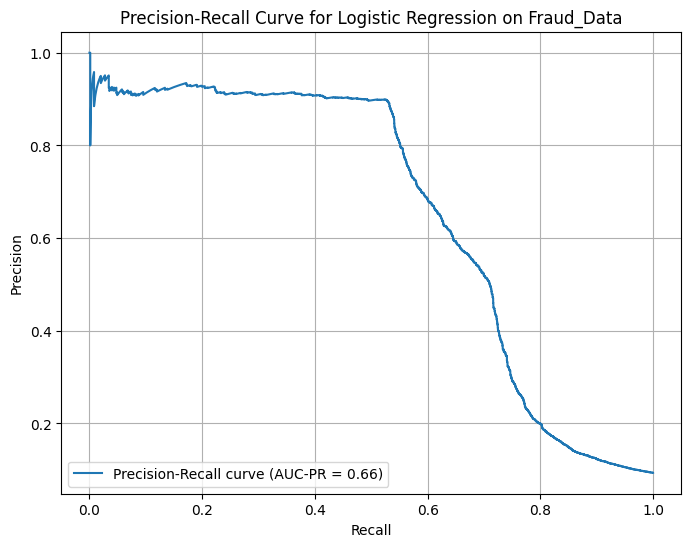


Training LightGBM for Fraud_Data...


  File "d:\Project\FraudDetection\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Project\FraudDetection\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Number of positive: 109568, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13580
[LightGBM] [Info] Number of data points in the train set: 219136, number of used features: 125
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- LightGBM on Fraud_Data - Confusion Matrix ---
[[27387     6]
 [ 1333  1497]]
True Negatives (TN): 27387
False Positives (FP): 6
False Negatives (FN): 1333
True Positives (TP): 1497
F1-Score: 0.6910
AUC-ROC: 0.8445
AUC-PR (Area Under Precision-Recall Curve): 0.7141
Average Precision Score: 0.7141


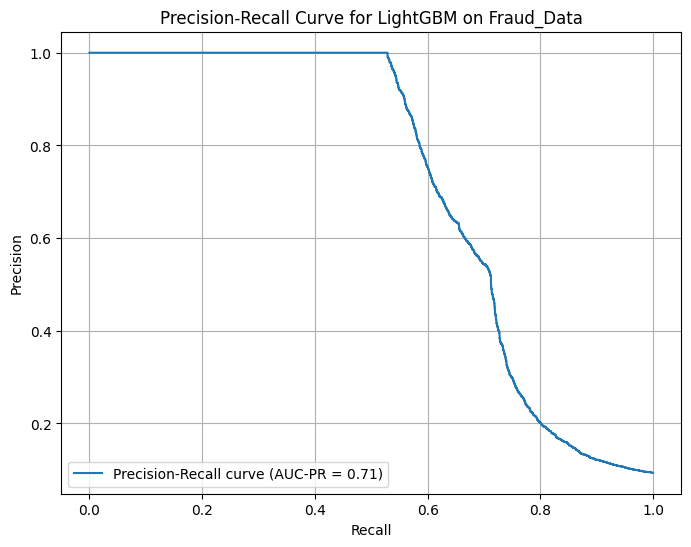


========== Training Models for CreditCard_Data ==========

Training Logistic Regression for CreditCard_Data...

--- Logistic Regression on CreditCard_Data - Confusion Matrix ---
[[55147  1504]
 [   12    83]]
True Negatives (TN): 55147
False Positives (FP): 1504
False Negatives (FN): 12
True Positives (TP): 83
F1-Score: 0.0987
AUC-ROC: 0.9625
AUC-PR (Area Under Precision-Recall Curve): 0.7164
Average Precision Score: 0.6780


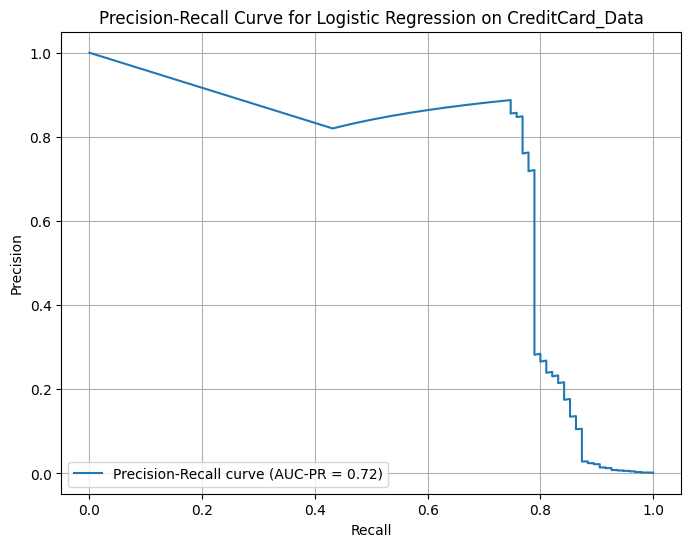


Training LightGBM for CreditCard_Data...
[LightGBM] [Info] Number of positive: 22660, number of negative: 226602
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 249262, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090908 -> initscore=-2.302594
[LightGBM] [Info] Start training from score -2.302594

--- LightGBM on CreditCard_Data - Confusion Matrix ---
[[56647     4]
 [   22    73]]
True Negatives (TN): 56647
False Positives (FP): 4
False Negatives (FN): 22
True Positives (TP): 73
F1-Score: 0.8488
AUC-ROC: 0.9723
AUC-PR (Area Under Precision-Recall Curve): 0.8038
Average Precision Score: 0.8040


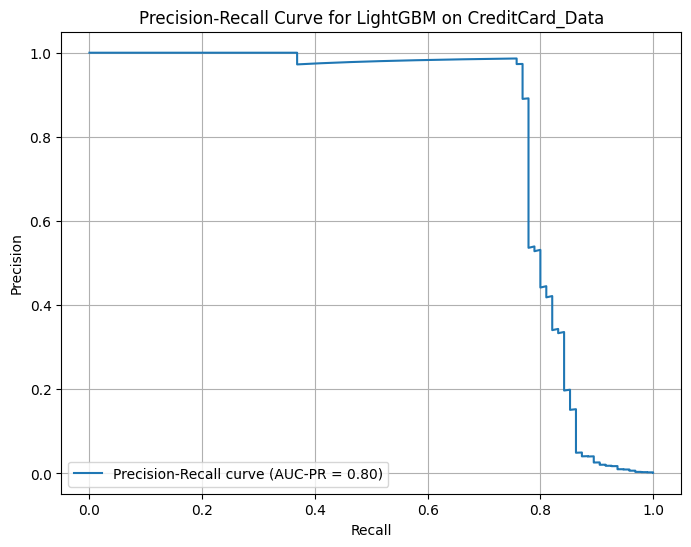


--- Task 2: Model Building and Training (modeling.ipynb) complete. ---


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier # Or from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, auc, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

# Suppress warnings for cleaner output in the notebook
warnings.filterwarnings('ignore')

print("--- Starting Task 2: Model Building and Training (modeling.ipynb) ---")

# --- ALL CODE FROM Task 1 (eda.ipynb) GOES HERE ---
# This ensures modeling.ipynb is self-contained and has all data prepared.

# --- 1. Load Datasets (from Task 1) ---
try:
    fraud_data = pd.read_csv('../data/Fraud_Data.csv')
    ip_to_country = pd.read_csv('../data/IpAddress_to_Country.csv')
    credit_card_data = pd.read_csv('../data/creditcard.csv')
    print("Datasets loaded successfully from '../data/'!")
except FileNotFoundError as e:
    print(f"Error loading files. Ensure your data files are in the 'data/' directory relative to this notebook: {e}")
    raise SystemExit("Data files not found. Please check paths and directory structure.")

# --- 2. Handle Missing Values (from Task 1) ---
# (As noted in Task 1, no explicit NaNs in raw data, handled by imputer in pipeline for engineered features)

# --- 3. Data Cleaning (from Task 1) ---
fraud_data.drop_duplicates(inplace=True)
ip_to_country.drop_duplicates(inplace=True)
credit_card_data.drop_duplicates(inplace=True)

fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['ip_address'] = pd.to_numeric(fraud_data['ip_address'], errors='coerce')
initial_fraud_rows = len(fraud_data)
fraud_data.dropna(subset=['ip_address'], inplace=True)
if len(fraud_data) < initial_fraud_rows:
    print(f"Dropped {initial_fraud_rows - len(fraud_data)} rows from Fraud_Data due to invalid IP addresses.")
fraud_data['ip_address'] = fraud_data['ip_address'].astype(np.int64)

ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].astype(np.int64)
ip_to_country['upper_bound_ip_address'] = ip_to_country['upper_bound_ip_address'].astype(np.int64)

# --- 4. EDA (from Task 1) ---
# (Plots and descriptive stats are typically for EDA. We won't re-run plot generation here
# to keep this notebook focused on modeling, but the data transformations from EDA are crucial.)

# --- 5. Merge Datasets for Geolocation Analysis (from Task 1) ---
ip_to_country_sorted = ip_to_country.sort_values(by='lower_bound_ip_address').reset_index(drop=True)

def get_country(ip_address, ip_ranges_df):
    idx = ip_ranges_df['lower_bound_ip_address'].searchsorted(ip_address, side='right') - 1
    if idx >= 0 and ip_address <= ip_ranges_df.loc[idx, 'upper_bound_ip_address']:
        return ip_ranges_df.loc[idx, 'country']
    return 'Unknown'

print("Applying IP to Country mapping for Fraud_Data...")
fraud_data['country'] = fraud_data['ip_address'].apply(lambda x: get_country(x, ip_to_country_sorted))
print("IP to Country mapping complete!")

# --- 6. Feature Engineering (from Task 1) ---
print("Extracting time-based and velocity features for Fraud_Data...")
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['day_of_year'] = fraud_data['purchase_time'].dt.dayofyear
fraud_data['month_of_year'] = fraud_data['purchase_time'].dt.month
fraud_data['week_of_year'] = fraud_data['purchase_time'].dt.isocalendar().week.astype(int)
fraud_data['time_since_signup_seconds'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()
fraud_data['time_since_signup_seconds'] = fraud_data['time_since_signup_seconds'].apply(lambda x: max(0, x))

fraud_data = fraud_data.sort_values(by=['user_id', 'purchase_time']).reset_index(drop=True)
fraud_data['time_diff_user'] = fraud_data.groupby('user_id')['purchase_time'].diff().dt.total_seconds()
fraud_data['time_diff_user'].fillna(0, inplace=True)

fraud_data = fraud_data.sort_values(by=['device_id', 'purchase_time']).reset_index(drop=True)
fraud_data['time_diff_device'] = fraud_data.groupby('device_id')['purchase_time'].diff().dt.total_seconds()
fraud_data['time_diff_device'].fillna(0, inplace=True)

fraud_data['device_transaction_count'] = fraud_data.groupby('device_id')['purchase_time'].transform('count')
fraud_data['user_transaction_count'] = fraud_data.groupby('user_id')['purchase_time'].transform('count')
print("Feature Engineering complete for Fraud_Data.")

# --- 7. Data Transformation (Define Pipelines - from Task 1) ---
# Define features for transformation pipelines for Fraud_Data
X_fraud_pre_split = fraud_data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'class'], axis=1)
y_fraud_pre_split = fraud_data['class']

numerical_features_fraud = X_fraud_pre_split.select_dtypes(include=np.number).columns.tolist()
categorical_features_fraud = X_fraud_pre_split.select_dtypes(include='object').columns.tolist()

# Preprocessing Pipeline Setup for Fraud_Data
numerical_transformer_fraud = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer_fraud = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor_fraud = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_fraud, numerical_features_fraud),
        ('cat', categorical_transformer_fraud, categorical_features_fraud)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline for Fraud_Data defined.")

# Define features for transformation pipelines for CreditCard_Data
X_credit_pre_split = credit_card_data.drop(['Class'], axis=1)
y_credit_pre_split = credit_card_data['Class']

numerical_features_credit = X_credit_pre_split.columns.tolist() # All features are numerical

# Preprocessing Pipeline Setup for CreditCard_Data
numerical_transformer_credit = Pipeline(steps=[
    ('scaler', StandardScaler())
])
preprocessor_credit = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_credit, numerical_features_credit)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline for CreditCard_Data defined.")

print("\n--- Task 1 Data Preparation complete. Proceeding to Task 2. ---")


# --- Task 2: Model Building and Training ---

# --- 8. Data Preparation: Separate features and target, and perform a train-test split. ---

# Train-Test Split for Fraud_Data
print("\n--- Performing Train-Test Split for Fraud_Data ---")
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud_pre_split, y_fraud_pre_split, test_size=0.2, random_state=42, stratify=y_fraud_pre_split
)
print(f"Fraud_Data - Training set shape: {X_train_fraud.shape}, {y_train_fraud.shape}")
print(f"Fraud_Data - Test set shape: {X_test_fraud.shape}, {y_test_fraud.shape}")
print("Fraud_Data - y_train_fraud class distribution:")
print(y_train_fraud.value_counts(normalize=True))
print("Fraud_Data - y_test_fraud class distribution:")
print(y_test_fraud.value_counts(normalize=True))

# Train-Test Split for CreditCard_Data
print("\n--- Performing Train-Test Split for CreditCard_Data ---")
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit_pre_split, y_credit_pre_split, test_size=0.2, random_state=42, stratify=y_credit_pre_split
)
print(f"CreditCard_Data - Training set shape: {X_train_credit.shape}, {y_train_credit.shape}")
print(f"CreditCard_Data - Test set shape: {X_test_credit.shape}, {y_test_credit.shape}")
print("CreditCard_Data - y_train_credit class distribution:")
print(y_train_credit.value_counts(normalize=True))
print("CreditCard_Data - y_test_credit class distribution:")
print(y_test_credit.value_counts(normalize=True))


# --- 9. Model Selection ---
print("\n--- Model Selection: Logistic Regression and LightGBM ---")
# Models will be defined within the pipelines below.

# --- 10. Model Training and Evaluation ---

def evaluate_model(model, X_test, y_test, model_name, dataset_name):
    """
    Evaluates a trained model and prints performance metrics suitable for imbalanced data.
    Plots the Precision-Recall Curve.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (fraud)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n--- {model_name} on {dataset_name} - Confusion Matrix ---")
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")

    # F1-Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.4f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # AUC-PR (Average Precision Score is equivalent to AUC-PR for binary classification)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    avg_precision = average_precision_score(y_test, y_proba) # Also AUC-PR
    print(f"AUC-PR (Area Under Precision-Recall Curve): {auc_pr:.4f}")
    print(f"Average Precision Score: {avg_precision:.4f}")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall curve (AUC-PR = {auc_pr:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name} on {dataset_name}')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return {'F1': f1, 'AUC-ROC': auc_roc, 'AUC-PR': auc_pr, 'Confusion Matrix': cm}


# --- Model Training and Evaluation for Fraud_Data ---
print("\n========== Training Models for Fraud_Data ==========")

# Logistic Regression Pipeline for Fraud_Data
# Using ImbPipeline to integrate SMOTE
pipeline_lr_fraud = ImbPipeline(steps=[
    ('preprocessor', preprocessor_fraud),
    ('smote', SMOTE(random_state=42)), # Apply SMOTE to training data
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])
print("\nTraining Logistic Regression for Fraud_Data...")
pipeline_lr_fraud.fit(X_train_fraud, y_train_fraud)
metrics_lr_fraud = evaluate_model(pipeline_lr_fraud, X_test_fraud, y_test_fraud, "Logistic Regression", "Fraud_Data")


# LightGBM Pipeline for Fraud_Data
pipeline_lgbm_fraud = ImbPipeline(steps=[
    ('preprocessor', preprocessor_fraud),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.05, num_leaves=31))
])
print("\nTraining LightGBM for Fraud_Data...")
pipeline_lgbm_fraud.fit(X_train_fraud, y_train_fraud)
metrics_lgbm_fraud = evaluate_model(pipeline_lgbm_fraud, X_test_fraud, y_test_fraud, "LightGBM", "Fraud_Data")


# --- Model Training and Evaluation for CreditCard_Data ---
print("\n========== Training Models for CreditCard_Data ==========")

# Logistic Regression Pipeline for CreditCard_Data
pipeline_lr_credit = ImbPipeline(steps=[
    ('preprocessor', preprocessor_credit),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)), # Smaller sampling_strategy for very high imbalance
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'))
])
print("\nTraining Logistic Regression for CreditCard_Data...")
pipeline_lr_credit.fit(X_train_credit, y_train_credit)
metrics_lr_credit = evaluate_model(pipeline_lr_credit, X_test_credit, y_test_credit, "Logistic Regression", "CreditCard_Data")


# LightGBM Pipeline for CreditCard_Data
pipeline_lgbm_credit = ImbPipeline(steps=[
    ('preprocessor', preprocessor_credit),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
    ('classifier', LGBMClassifier(random_state=42, n_estimators=500, learning_rate=0.05, num_leaves=31))
])
print("\nTraining LightGBM for CreditCard_Data...")
pipeline_lgbm_credit.fit(X_train_credit, y_train_credit)
metrics_lgbm_credit = evaluate_model(pipeline_lgbm_credit, X_test_credit, y_test_credit, "LightGBM", "CreditCard_Data")

print("\n--- Task 2: Model Building and Training (modeling.ipynb) complete. ---")
